In [8]:
import numpy as np
import pandas as pd
import collections
from collections import OrderedDict
import pytorch_lightning as L
import os
import re
import json
import tqdm

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
# from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from pymatgen.core.composition import Composition
from crabnet.kingcrab import CrabNet

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR, StepLR

from crabnet.utils.utils import (Lamb, Lookahead, RobustL1, CrossEntropyLoss,
                         EDMDataset, get_edm, Scaler, DummyScaler, count_parameters)
from crabnet.utils.get_compute_device import get_compute_device
# from crabnet.utils.composition import _element_composition, get_sym_dict, parse_formula, CompositionError
#from utils.optim import SWA

data_type_np = np.float32
data_type_torch = torch.float32

import wandb


class CrabNetDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str,
                 n_elements ='infer', 
                 classification = False,
                 elem_prop='mat2vec',
                 batch_size = 2**10,
                 scale = True,
                 pin_memory = True):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.n_elements=n_elements
        self.pin_memory = pin_memory
        self.scale = scale
        self.classification = classification
        self.elem_prop=elem_prop

    def prepare_data(self):
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_main_data = list(get_edm(self.data_train, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=False,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.train_len_data = len(self.train_main_data[0])
        self.train_n_elements = self.train_main_data[0].shape[1]//2

        print(f'loading data with up to {self.train_n_elements:0.0f} '
              f'elements in the formula for training')
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_main_data = list(get_edm(self.data_val, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.val_len_data = len(self.val_main_data[0])
        self.val_n_elements = self.val_main_data[0].shape[1]//2

        print(f'loading data with up to {self.val_n_elements:0.0f} '
              f'elements in the formula for validation')
        
        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_main_data = list(get_edm(self.data_test, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.test_len_data = len(self.test_main_data[0])
        self.test_n_elements = self.test_main_data[0].shape[1]//2

        print(f'loading data with up to {self.test_n_elements:0.0f} '
              f'elements in the formula for testing')

        self.train_dataset = EDMDataset(self.train_main_data, self.train_n_elements)
        self.val_dataset = EDMDataset(self.val_main_data, self.val_n_elements)
        self.test_dataset = EDMDataset(self.test_main_data, self.test_n_elements)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          pin_memory=self.pin_memory, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                        pin_memory=self.pin_memory, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)


class CrabNetLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = CrabNet(out_dims=config['out_dims'],
                             d_model=config['d_model'],
                             N=config['N'],
                             heads=config['heads'])
        print('\nModel architecture: out_dims, d_model, N, heads')
        print(f'{self.model.out_dims}, {self.model.d_model}, '
                  f'{self.model.N}, {self.model.heads}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')

        ### here we define some important parameters
        self.fudge=config['fudge']
        self.batch_size=config['batch_size']
        self.classification = config['classification']
        self.base_lr=config['base_lr']
        self.max_lr=config['max_lr']
        
        self.criterion = CrossEntropyLoss
        
        if(re.search('.json', config['train_path'] )):
            train_data=pd.read_json(config['train_path'])
        elif(re.search('.csv', config['train_path'])):
            train_data=pd.read_csv(config['train_path'])
        
        y=train_data['target'].values
        self.step_size = len(y)

    def forward(self, src, frac):
        out=self.model(src, frac)
        return out

    def configure_optimizers(self):
        base_optim = Lamb(params=self.model.parameters(),lr=0.001)
        optimizer = Lookahead(base_optimizer=base_optim)
        lr_scheduler = CyclicLR(optimizer,
                                base_lr=self.base_lr,
                                max_lr=self.max_lr,
                                cycle_momentum=False,
                                step_size_up=self.step_size)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=3,
        #                     gamma=0.5)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        X, y, formula = batch
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        prediction = self(src, frac)
        loss = self.criterion(prediction,y)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        prediction = torch.nn.functional.softmax(prediction,dim=1)
        y_pred = torch.argmax(prediction,dim=1)
        y=y.detach().cpu().numpy()
        y_pred=y_pred.detach().cpu().numpy()
        acc=balanced_accuracy_score(y,y_pred)
        f1=f1_score(y,y_pred,average='macro')
        mc=matthews_corrcoef(y,y_pred)
            
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, batch_idx):
        X, y, formula = batch
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        prediction = self(src, frac)
        val_loss = self.criterion(prediction,y)
        
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        prediction = torch.nn.functional.softmax(prediction,dim=1)
        y_pred = torch.argmax(prediction,dim=1)
        y=y.detach().cpu().numpy()
        y_pred=y_pred.detach().cpu().numpy()
        acc=balanced_accuracy_score(y,y_pred)
        f1=f1_score(y,y_pred,average='macro')
        mc=matthews_corrcoef(y,y_pred)
            
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("val_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return val_loss
     
    def test_step(self, batch, batch_idx):
        X, y, formula = batch
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        prediction = self(src, frac)
        
        prediction = torch.nn.functional.softmax(prediction,dim=1)
        y_pred = torch.argmax(prediction,dim=1)
        y=y.detach().cpu().numpy()
        y_pred=y_pred.detach().cpu().numpy()
        acc=balanced_accuracy_score(y,y_pred)
        f1=f1_score(y,y_pred,average='macro')
        mc=matthews_corrcoef(y,y_pred)
            
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("test_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        X, y, formula = batch
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        prediction = self(src, frac)
        prediction = torch.nn.functional.softmax(prediction,dim=1)
        y_pred = torch.argmax(prediction,dim=1)
        y=y.detach().cpu().numpy()
        y_pred=y_pred.detach().cpu().numpy()
        acc=balanced_accuracy_score(y,y_pred)
        f1=f1_score(y,y_pred,average='macro')
        mc=matthews_corrcoef(y,y_pred)        
        return formula, y_pred, prediction




In [2]:
with open('crabnet/crabnet_config.json','r') as f:
        config=json.load(f)

L.seed_everything(config['random_seed'])

Global seed set to 27


27

In [3]:
model = CrabNetLightning(**config)
# wandb_logger = WandbLogger(project="Crabnet-global-disorder-new", config=config, log_model="all")
trainer = Trainer(max_epochs=100,accelerator='gpu', devices=1, 
                      callbacks=[StochasticWeightAveraging(swa_epoch_start=config['swa_epoch_start'],swa_lrs=config['swa_lrs']),
                                EarlyStopping(monitor='val_loss', patience=config['patience']), ModelCheckpoint(monitor='val_acc', mode="max", 
                                dirpath='crabnet_models/crabnet_trained_models/', filename='disorder-{epoch:02d}-{val_acc:.2f}')])
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])
trainer.fit(model, datamodule=disorder_data)
trainer.test(ckpt_path='best',datamodule=disorder_data)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 214564.88formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 210117.56formulae/s]

loading data with up to 13 elements in the formula for validation

Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 213622.22formulae/s]
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory crabnet_models/crabnet_trained_models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | CrabNet | 12.0 M
----------------------------------
12.0 M    Trainable params
23.8 K    Non-trainable params
12.0 M    Total params
48.045    Total estima

loading data with up to 15 elements in the formula for testing


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Swapping scheduler `CyclicLR` for `SWALR`


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 208917.90formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 196481.50formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 206462.13formulae/s]
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at crabnet_models/crabnet_trained_models/disorder-epoch=40-val_acc=0.78.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at crabnet_models/crabnet_trained_models/disorder-epoch=40-val_acc=0.78.ckpt


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7757253178090717
         test_f1            0.7796478968013522
         test_mc            0.7487202552310397
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7757253178090717,
  'test_f1': 0.7796478968013522,
  'test_mc': 0.7487202552310397}]

In [60]:
from sklearn.metrics import recall_score,average_precision_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for x in disorder_data.predict_dataloader():
        _, y_true, _ = x
model=CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/crabnet-type-disorder-0.ckpt')
trainer=Trainer()
formula, y_pred, prediction=trainer.predict(model=model, datamodule=disorder_data)[0]
    
metrics={}
metrics['acc']=balanced_accuracy_score(y_true,y_pred)
metrics['f1']=f1_score(y_true,y_pred,average='macro')
metrics['precision']=average_precision_score(y_true,y_pred.reshape(-1, 1),average='macro')
metrics['recall']=recall_score(y_true,y_pred,average='macro')
metrics['mc']=matthews_corrcoef(y_true,y_pred)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 201109.72formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 185740.85formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 186759.71formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

In [61]:
metrics

{'acc': 0.775638331031062,
 'f1': 0.7795809319798652,
 'precision': 0.3506962667213484,
 'recall': 0.775638331031062,
 'mc': 0.748639494554961}

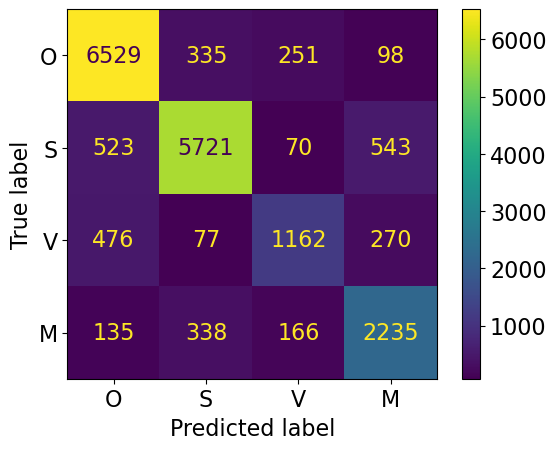

In [62]:
cm=confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['O','S','V','M'])
disp.plot()
plt.show()

In [ ]:
6362/(6362+371+388+92)

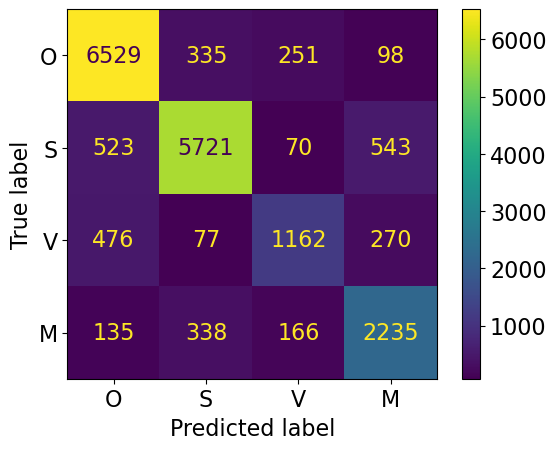

In [14]:
cm=confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['O','S','V','M'])
disp.plot()
plt.show()

In [19]:
with open('crabnet/crabnet_config.json','r') as f:
        config=json.load(f)
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])
disorder_data.prepare_data()
predictloader=disorder_data.predict_dataloader()
for x in predictloader:
    _,y_true,_=x
    datalength=len(y_true)

prediction_crabnet=np.zeros((10,datalength,4))


Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 216105.51formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 213082.25formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 213596.93formulae/s]


loading data with up to 15 elements in the formula for testing


In [32]:
np.shape(prediction_crabnet)

(10, 18929, 4)

In [29]:
for i in range(10):
    name='crabnet-type-disorder-'+str(i)
    model = CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/'+name+'.ckpt')
    trainer = Trainer()
    formula, ypred, prediction=trainer.predict(model=model,datamodule=disorder_data)[0]
    prediction_crabnet[i,:,:]=prediction.detach().cpu().numpy()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 214131.48formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 199021.60formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 208463.58formulae/s]


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 211718.95formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 207228.84formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 203342.29formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 211710.17formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 207236.95formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 210123.70formulae/s]


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 216234.84formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 209984.20formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 205550.76formulae/s]


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 206909.03formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 204463.21formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 209755.65formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 207212.06formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 207234.25formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 202107.22formulae/s]


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 8
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 205877.78formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 210125.91formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 207812.62formulae/s]


loading data with up to 15 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 210091.35formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 213033.65formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 207818.06formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 211595.28formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 211304.45formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 206583.54formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
4, 512, 3, 4
Model size: 11987335 parameters



C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 68141/68141 [00:00<00:00, 205849.76formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 7572/7572 [00:00<00:00, 204457.94formulae/s]


loading data with up to 13 elements in the formula for validation


Generating EDM: 100%|██████████| 18929/18929 [00:00<00:00, 209328.15formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 15 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

In [39]:
y_pred_ens=np.zeros((10,datalength))
for i in range(10):
    y_pred=np.argmax(prediction_crabnet[i,:,:],axis=-1)
    y_pred_ens[i,:]=y_pred

In [50]:
labels=[]
for i in range(datalength):
    a=y_pred_ens[:,i].astype(int)
    counts = np.bincount(a)
    labels.append(np.argmax(counts))
    


In [52]:
y_pred = labels

In [55]:
metrics={}
metrics['acc']=balanced_accuracy_score(y_true,y_pred)
metrics['f1']=f1_score(y_true,y_pred,average='macro')
metrics['recall']=recall_score(y_true,y_pred,average='macro')
metrics['mc']=matthews_corrcoef(y_true,y_pred)

In [56]:
metrics

{'acc': 0.8026207887528969,
 'f1': 0.8115935759711704,
 'recall': 0.8026207887528969,
 'mc': 0.7885254348161043}

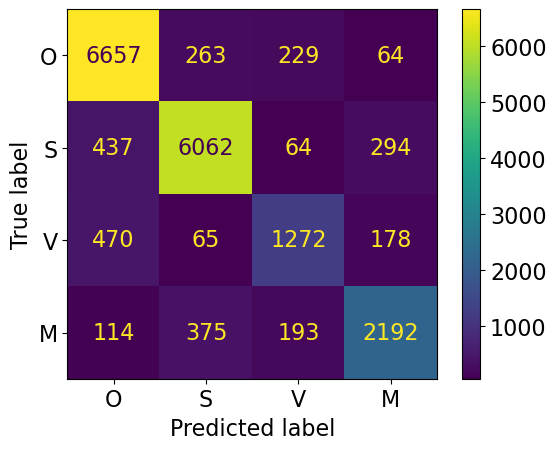

In [57]:
cm=confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['O','S','V','M'])
disp.plot()
plt.show()

In [21]:
x=torch.randn(12,4)

In [23]:
y=np.zeros((10,12,4))

In [24]:
y[0,:,:]=x

In [28]:
y[2]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])